In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-20 09:29:39--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.04s   

2025-10-20 09:29:39 (1.78 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [105]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold

In [3]:
raw_leads_df = pd.read_csv("course_lead_scoring.csv")
raw_leads_df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
# define numerical and categorical columns
numerical_columns = ["annual_income", "lead_score", 'interaction_count', 'number_of_courses_viewed', 'converted']
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']

In [5]:
# Clean up missing values
cleaned_leads_df = raw_leads_df.copy()
cleaned_leads_df[numerical_columns] = cleaned_leads_df[numerical_columns].fillna(0.0)
cleaned_leads_df[categorical_columns] = cleaned_leads_df[categorical_columns].fillna('NA')

cleaned_leads_df.isnull().sum()


,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


In [111]:
from sklearn.model_selection import train_test_split

full_df = cleaned_leads_df.copy()

df_full_train, df_test = train_test_split(full_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(full_df), len(df_train), len(df_test), len(df_val)

(1462, 876, 293, 293)

In [20]:
df_train

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
462,events,manufacturing,2,95543.0,unemployed,europe,3,0.78,0
135,referral,NA,1,54924.0,student,south_america,6,0.39,1
117,organic_search,healthcare,2,77352.0,unemployed,europe,2,0.22,0
1051,paid_ads,other,2,34600.0,employed,south_america,2,0.31,0
945,paid_ads,education,0,43615.0,unemployed,south_america,2,0.01,0
...,...,...,...,...,...,...,...,...,...
39,NA,other,5,67314.0,NA,europe,2,0.87,1
1261,events,education,6,63996.0,NA,australia,4,0.92,1
595,organic_search,finance,1,73702.0,unemployed,north_america,2,0.55,0
1329,events,technology,1,93341.0,student,middle_east,4,0.99,0


In [23]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

**Question 1**

In [30]:
numerical_features = ["lead_score", 'interaction_count', 'number_of_courses_viewed', "annual_income", ]

aucs = []

for feature in numerical_features:
  aucs.append(
      {
          "feature": feature,
          "auc": roc_auc_score(y_train, df_train[feature])
      }
  )

pd.DataFrame(aucs)

,feature,auc
0,lead_score,0.614499
1,interaction_count,0.738270
2,number_of_courses_viewed,0.763568
3,annual_income,0.551958


Answser: "number_of_courses_viewed"

**Question 2**

In [31]:
from sklearn.feature_extraction import DictVectorizer

numerical_columns = ["annual_income", "lead_score", 'interaction_count', 'number_of_courses_viewed']

dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical_columns + categorical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[numerical_columns + categorical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[numerical_columns + categorical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [39]:
y_pred_probabilities = model.predict_proba(X_val)[:, 1]
y_pred_decision = y_pred_probabilities >= 0.5
y_pred = y_pred_decision.astype(int)

roc_auc_score(y_val, y_pred).round(2)

np.float64(0.65)

Answer: 0.72

**Question 3**

In [90]:
scores = []

thresholds = np.linspace(0, 1, 101)

precision_recall_list = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred_probabilities >= t)
    predict_negative = (y_pred_probabilities < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp) if tp else 0
    recall = tp / (tp + fn) if tp else 0

    multiplier = 2 * precision * recall
    f1 = 0 if precision == 0 and recall == 0 else multiplier / (precision + recall)

    precision_recall_list.append(
        {
            "threshhold": t,
            "precision": precision,
            "recall": recall,
            "difference": precision - recall,
            "f1": f1
        }
    )

precision_recall_df = pd.DataFrame(precision_recall_list)



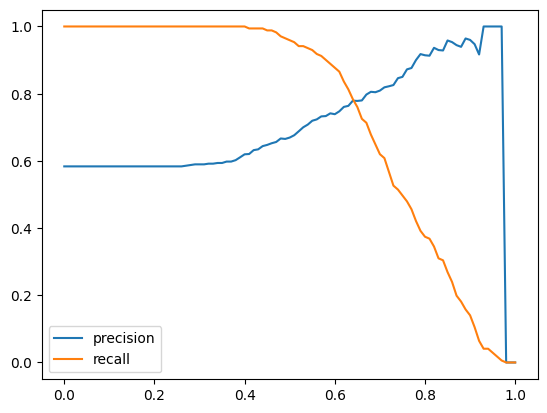

In [86]:
plt.plot(precision_recall_df.threshhold, precision_recall_df['precision'], label='precision')
plt.plot(precision_recall_df.threshhold, precision_recall_df['recall'], label='recall')
plt.legend()


Answer: 0.545

**Question 4**

In [103]:
max_value = precision_recall_df["f1"].max()

precision_recall_df[precision_recall_df["f1"] == max_value]

,threshhold,precision,recall,difference,f1
57,0.57,0.732394,0.912281,-0.179886,0.8125


Answer: 0.54

**Question 5**

In [119]:
def train_and_validate(kfold_train_df, kfold_valid_df, C=1):
  kfold_y_train = kfold_train_df.converted.values
  kfold_y_val = kfold_valid_df.converted.values

  del kfold_train_df['converted']
  del kfold_valid_df['converted']

  numerical_columns = ["annual_income", "lead_score", 'interaction_count', 'number_of_courses_viewed']

  dv = DictVectorizer(sparse=False)

  train_dict = kfold_train_df[numerical_columns + categorical_columns].to_dict(orient='records')
  kfold_X_train = dv.fit_transform(train_dict)

  val_dict = kfold_valid_df[numerical_columns + categorical_columns].to_dict(orient='records')
  kfold_X_val = dv.transform(val_dict)

  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

  model.fit(kfold_X_train, kfold_y_train)

  kfold_y_pred_probabilities = model.predict_proba(kfold_X_val)[:, 1]
  kfold_y_pred_decision = kfold_y_pred_probabilities >= 0.5
  kfold_y_pred = kfold_y_pred_decision.astype(int)

  return roc_auc_score(kfold_y_val, kfold_y_pred)



In [118]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []

for kfold_train_idx, kfold_val_idx in kfold.split(full_df):
  kfold_full_df = full_df.copy()
  aucs.append(train_and_validate(
      kfold_full_df.iloc[kfold_train_idx],
      kfold_full_df.iloc[kfold_val_idx])
  )

np.std(aucs)


np.float64(0.02744746957328963)

Answer: 0.06

**Question 6**

In [121]:
means = []

for coef in [0.000001, 0.001, 1]:

  scores = []

  for kfold_train_idx, kfold_val_idx in kfold.split(full_df):
    kfold_full_df = full_df.copy()
    scores.append(train_and_validate(
        kfold_full_df.iloc[kfold_train_idx],
        kfold_full_df.iloc[kfold_val_idx],
        coef
        )
    )

  means.append(
      {
          "coef": coef,
          "mean_score": np.mean(scores).round(3)
      }
  )

pd.DataFrame(means)


,coef,mean_score
0,0.000001,0.500
1,0.001000,0.510
2,1.000000,0.666


Answer: 1